# Create a phasogram

In [2]:
# Remove warnings
import warnings
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset, SpectrumDataset
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator
from gammapy.makers import (
    MapDatasetMaker,
    PhaseBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.stats import WStatCountsStatistic
from gammapy.utils.regions import SphericalCircleSkyRegion

warnings.filterwarnings("ignore")

In [34]:
datastore = DataStore.from_dir("DL3_lstchain_v0.10.9/",
                               hdu_table_filename="hdu-index-pulsar.fits.gz")
observations = datastore.get_observations(required_irf="point-like")

In [35]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region = SphericalCircleSkyRegion(target_position, 0.2*u.deg)

In [108]:
# Apply angular selection
events = []
phases
for obs in observations:
    evc = obs.events.select_rad_max(obs.rad_max, position=target_position)
    events.append(evc)

In [109]:

phases = []
for ev in events:
    phases.extend(ev.table["PHASE"].data)

phases=np.array(phases)

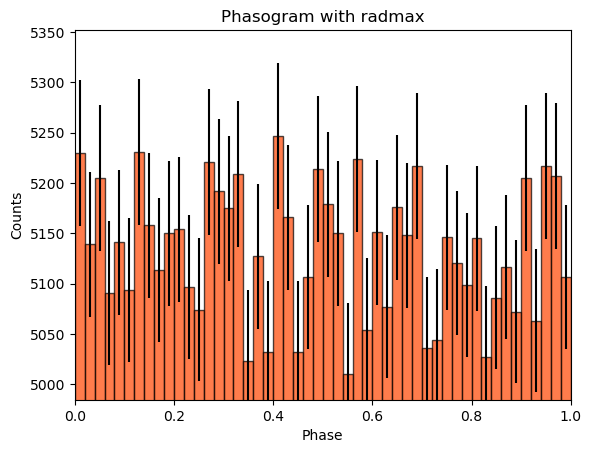

In [116]:
nbins = 50
phase_min, phase_max = (0, 1)
values, bin_edges = np.histogram(phases, range=(phase_min, phase_max), bins=nbins)
bin_width = (phase_max - phase_min) / nbins

bin_center = (bin_edges[:-1] + bin_edges[1:]) / 2

# Poissonian uncertainty on each bin
values_err = np.sqrt(values)

fig, ax = plt.subplots()
ax.bar(
    x=bin_center,
    height=values,
    width=bin_width,
    color="orangered",
    alpha=0.7,
    edgecolor="black",
    yerr=values_err,
)
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0.95*np.max(values), top=1.02*np.max(values))
ax.set_xlabel("Phase")
ax.set_ylabel("Counts")
ax.set_title(f"Phasogram with radmax")
plt.show()





In [117]:
on_phase_range = (0.35, 0.45)
off_phase_range = (0.6, 0.9)

# Evaluate background level
mask_off = (off_phase_range[0] < phases) & (phases < off_phase_range[1])

count_bkg = mask_off.sum()
print(f"Number of Off events: {count_bkg}")

# bkg level normalized by the size of the OFF zone (0.3)
bkg = count_bkg / nbins / (off_phase_range[1] - off_phase_range[0])

# error on the background estimation
bkg_err = np.sqrt(count_bkg) / nbins / (off_phase_range[1] - off_phase_range[0])

Number of Off events: 76662


In [118]:
# Calculate the ratio between the on-phase and the off-phase
alpha = (on_phase_range[1] - on_phase_range[0]) / (
    off_phase_range[1] - off_phase_range[0]
)


# Select events in phase space
on_events = phases[phases>on_phase_range[0]]
on_events = on_events[on_events<on_phase_range[1]]

off_events = phases[phases>off_phase_range[0]]
off_events = off_events[off_events<off_phase_range[1]]

In [119]:

# Apply the WStat (Li&Ma statistic)
pulse_stat = WStatCountsStatistic(
    len(on_events), len(off_events), alpha=alpha
)

print(f"Number of excess counts: {pulse_stat.n_sig}")
print(f"TS: {pulse_stat.ts}")
print(f"Significance: {pulse_stat.sqrt_ts}")

Number of excess counts: 41.99999999999636
TS: 0.05173729220405221
Significance: 0.22745833069828902
